In [27]:
!pip install flair datasets seqeval matplotlib seaborn --quiet

In [28]:
import flair
from flair.data import Sentence
from flair.models import SequenceTagger
from datasets import load_dataset
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [29]:
# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003")

test_dataset = dataset['test']

test_dataset = test_dataset.select(range(200))

label_list = dataset['train'].features['ner_tags'].feature.names

def map_labels(example):
    example['labels'] = [label_list[idx] for idx in example['ner_tags']]
    return example

test_dataset = test_dataset.map(map_labels)

In [30]:
# Load the Flair NER model
tagger = SequenceTagger.load("flair/ner-english-fast")

2024-10-21 09:46:21,763 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


Since Flair will tokenize the raw text internally, the tokens in sentence may not align perfectly with the original tokens. For evaluation, we'll extract entities (spans) from both the predictions and the ground truth and compare them at the entity level.

**Function to extract entities from ground truth labels:**

In [23]:
def get_entities(tokens, labels):
    entities = []
    entity_tokens = []
    entity_label = None
    for token, label in zip(tokens, labels):
        if label == 'O':
            if entity_tokens:
                entities.append((' '.join(entity_tokens), entity_label))
                entity_tokens = []
                entity_label = None
        else:
            label_type, label_class = label.split('-', maxsplit=1)
            if label_type == 'B':
                if entity_tokens:
                    entities.append((' '.join(entity_tokens), entity_label))
                entity_tokens = [token]
                entity_label = label_class
            elif label_type == 'I':
                if entity_tokens and entity_label == label_class:
                    entity_tokens.append(token)
                else:
                    if entity_tokens:
                        entities.append((' '.join(entity_tokens), entity_label))
                    entity_tokens = [token]
                    entity_label = label_class
    if entity_tokens:
        entities.append((' '.join(entity_tokens), entity_label))
    return entities

all_true_entities = []
all_predicted_entities = []

for idx, example in enumerate(test_dataset):
    tokens = example['tokens']
    labels = example['labels']
    text = ' '.join(tokens)
    # Build the sentence for Flair
    sentence = Sentence(text)
    # Run NER tagger
    tagger.predict(sentence)
    # Get predicted entities
    predicted_entities = []
    for entity in sentence.get_spans('ner'):
        entity_text = entity.text
        entity_label = entity.get_label('ner').value
        predicted_entities.append((entity_text, entity_label))
    # Get ground truth entities
    true_entities = get_entities(tokens, labels)
    all_true_entities.append(true_entities)
    all_predicted_entities.append(predicted_entities)

In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np

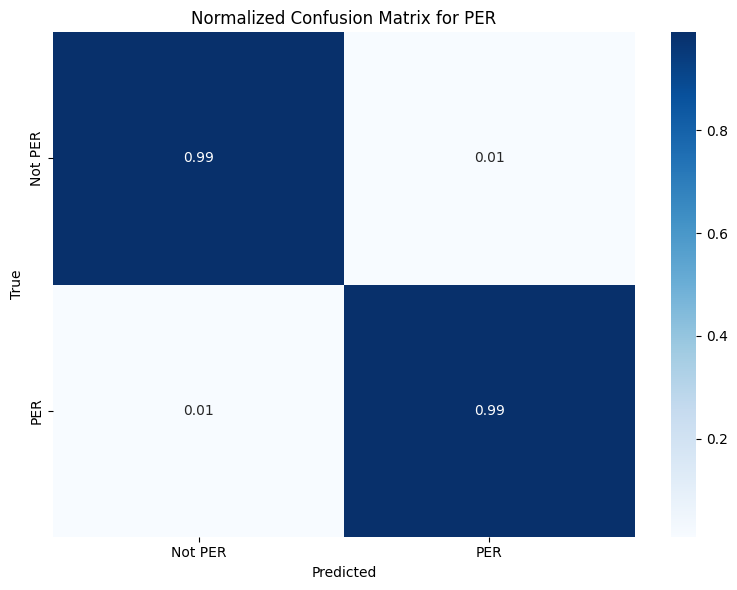

Precision for PER: 0.99
Recall for PER: 0.99
F1-score for PER: 0.99

Number of false positives (incorrectly labeled as PER): 1
Number of false negatives (PER missed by the model): 1

Examples of errors:
True entities: [('JAPAN', 'LOC'), ('CHINA', 'PER')]
Predicted entities: [('JAPAN', 'LOC'), ('CHINA', 'LOC')]
---
True entities: [('Pau-Orthez', 'ORG'), ('France', 'LOC')]
Predicted entities: [('Pau-Orthez', 'PER'), ('France', 'LOC')]
---


In [25]:
def get_binary_labels(entities, target_label='PER'):
    return [1 if any(label == target_label for _, label in entity_list) else 0 for entity_list in entities]

# Преобразуем сущности в бинарные метки (PER vs. не-PER)
y_true = get_binary_labels(all_true_entities)
y_pred = get_binary_labels(all_predicted_entities)

# Создаем матрицу ошибок
cm = confusion_matrix(y_true, y_pred)

# Нормализуем матрицу
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Определяем метки для осей
labels = ['Not PER', 'PER']

# Строим тепловую карту
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Normalized Confusion Matrix for PER')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Выводим метрики
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision for PER: {precision:.2f}")
print(f"Recall for PER: {recall:.2f}")
print(f"F1-score for PER: {f1_score:.2f}")

# Анализ ошибок
false_positives = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 1)
false_negatives = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 0)

print(f"\nNumber of false positives (incorrectly labeled as PER): {false_positives}")
print(f"Number of false negatives (PER missed by the model): {false_negatives}")

# Примеры ошибок
print("\nExamples of errors:")
for true_entities, pred_entities, true_label, pred_label in zip(all_true_entities, all_predicted_entities, y_true, y_pred):
    if true_label != pred_label:
        print("True entities:", true_entities)
        print("Predicted entities:", pred_entities)
        print("---")




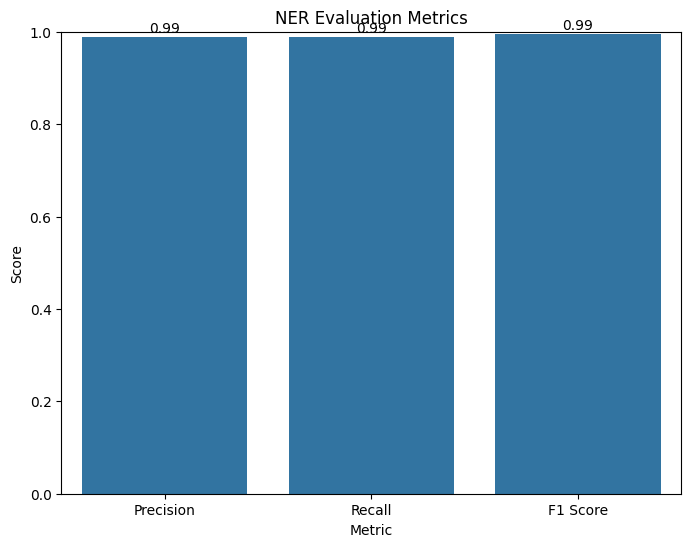

In [26]:
# Plotting
metrics = {'Metric': ['Precision', 'Recall', 'F1 Score'],
           'Score': [precision, recall, f1]}

df = pd.DataFrame(metrics)

plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Score', data=df)
plt.title('NER Evaluation Metrics')
plt.ylim(0, 1)
for index, row in df.iterrows():
    plt.text(index, row.Score + 0.01, f"{row.Score:.2f}", color='black', ha="center")
plt.show()